In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as m
import astropy.units as unit
import astropy.constants as cte

plt.style.use('dark_background')

In [2]:
"""
    CI : array-like that contains [x0, y0, vx0, vy0] in dimensionless units.
"""

def ax(x,y,CI):
    alpha = float(3*cte.G*cte.M_sun/(cte.c**2*cte.au))*(CI[3]*CI[0] - CI[1]*CI[2])
    return (-1/(x**2 + y**2) - 3*alpha/(x**2 + y**2)**2) * x/np.sqrt(x**2+y**2)

def ay(x,y,CI):
    alpha = float(3*cte.G*cte.M_sun/(cte.c**2*cte.au))*(CI[3]*CI[0] - CI[1]*CI[2])
    return (-1/(x**2 + y**2) - 3*alpha/(x**2 + y**2)**2) * y/np.sqrt(x**2+y**2)

def Energia(x, y, vx, vy, CI):
    alpha = float(3*cte.G*cte.M_sun/(cte.c**2*cte.au))*(CI[3]*CI[0] - CI[1]*CI[2])
    E = 1/2*(vx**2 + vy**2) - 1/np.sqrt(x**2 + y**2) - alpha/(3*np.sqrt(x**2 + y**2)**3)
    return E

def MomentoAngular(x,y,vx,vy): #Componente z
    return vy*x - y*vx

### Método RK4:

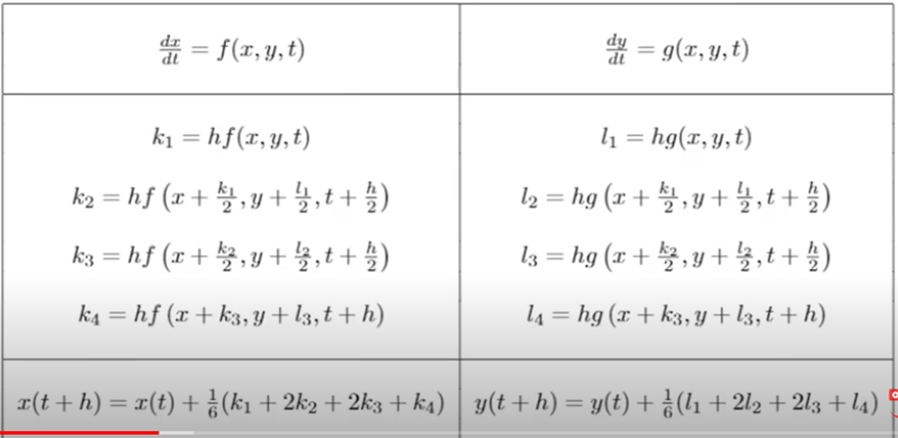

In [136]:
def RK4(x0,y0,vx0,vy0,n,h,box=2):
    """ 
        [x0, y0, vx0, vy0] : initial conditions
        n : number of steps
        h : time lapse between each step
        box : size of the plot
    """
    CI = [x0, y0, vx0, vy0]
    x = np.zeros(n); y = np.zeros(n); # Arrays vacíos para posteriormente llenarlos
    vx = np.zeros(n); vy = np.zeros(n)
    E = np.zeros(n)
    x[0] = x0; y[0] = y0; vx[0] = vx0; vy[0] = vy0
    E[0] = Energia(x[0], y[0], vx[0], vy[0],CI)
    Error = np.zeros(n)
    
    def siguiente_valor(x,y,vx,vy,h):
        """
        Dado unos datos iniciales en el tiempo t0 está función halla los datos
        en el tiempo t0+h. Para ello emplea 4 RK4 simultaneos, uno para cada variable
        x,y,vx,vy.
        """
        k1 = h*np.array([vx, vy, ax(x,y,CI), ay(x,y,CI)])
        x1 = x + k1[0]/2
        y1 = y + k1[1]/2
        vx1 = vx + k1[2]/2
        vy1 = vy + k1[3]/2
        
        k2 = h*np.array([vx1, vy1, ax(x1,y1,CI), ay(x1,y1,CI)])
        x2 = x + k2[0]/2
        y2 = y + k2[1]/2
        vx2 = vx + k2[2]/2
        vy2 = vy + k2[3]/2
        
        k3 = h*np.array([vx2, vy2, ax(x2,y2,CI), ay(x2,y2,CI)])
        x3 = x + k3[0]
        y3 = y + k3[1]
        vx3 = vx + k3[2]
        vy3 = vy + k3[3]
        
        k4 = h*np.array([vx3, vy3, ax(x3,y3,CI), ay(x3,y3,CI)])
        xf = x + 1/6 * (k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
        yf = y + 1/6 * (k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
        vxf = vx + 1/6 * (k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
        vyf = vy + 1/6 * (k1[3] + 2*k2[3] + 2*k3[3] + k4[3])
        return [xf,yf, vxf, vyf]
    
    def siguiente_valor_mejorado(x,y,vx,vy,h):
        sig0 = np.array(siguiente_valor(x,y,vx,vy,h))       # Cálculo con paso h
        sig1 = np.array(siguiente_valor(x,y,vx,vy,h/2))     # Cálculo 1 con paso h/2
        x1, y1, vx1, vy1 = sig1
        sig2 = np.array(siguiente_valor(x1,y1,vx1,vy1,h/2)) # Cálculo 2 con paso h/2
        Error = abs(sig2-sig0)/15
        return sig2+Error, Error[0]
        
    for i in range(n-1):
        sig, error = siguiente_valor_mejorado(x[i], y[i], vx[i], vy[i],h)
        Error[i+1] = error
        x[i+1] = sig[0]
        y[i+1] = sig[1]
        vx[i+1] = sig[2]
        vy[i+1] = sig[3]
        E[i+1] = Energia(x[i+1], y[i+1], vx[i+1], vy[i+1],CI)
    
    # Gráfico
    plot_orbit(x,y,box)
    r = np.sqrt(x**2+y**2)
    Lz = x*vy - y*vx
    df = pd.DataFrame({'t':t, 'x': x, 'y': y, 'vx': vx, 'vy': vy, 'r':r, 'L':Lz, 'E':E, 'Error':Error})
    return df

def plot_orbit(x,y,box):
    plt.figure(figsize=(10,5))
    plt.plot(x,y, lw=1)
    plt.scatter(0,0, marker=(5,1), s=200, color="yellow") #Estrella
    plt.xlim(-2*box,2*box); plt.ylim(-box,box) # Límites de los ejes
    plt.title('Trayectoria')
    plt.xlabel(r'$\overline{x}$',fontsize=13); plt.ylabel(r'$\overline{y}$',fontsize=13)
    plt.show()

### Hallando posiciones y velocidades iniciales

In [137]:
"""
    Aquí se considera la aproximación Newtoniana del campo gravitacional
"""
def select_conditions(r0,verbose=False):
    R = unit.au          # Distancia adimensional. Es la distancia Tierra-Sol
    M = unit.M_sun       # Masa del sol
    k = cte.G*M/R**2     # Constante de adimensionalización
    t_ad = np.sqrt(R/k)  # Tiempo adimensional  

    Rorb = r0*R        # Radio orbital al que deseamos poner el planeta, medido en unidades de distancia

    Vcirc = np.sqrt(cte.G*M / Rorb)  # Velocidad circular
    FrecAng = Vcirc/Rorb             # Frecuencia angular
    Torb = 2*np.pi/FrecAng           # Periodo orbital
    if verbose:
        print('V_ad = ',Vcirc/np.sqrt(k*R)) # Velocidad orbital en unidades adimencionales
        print('Rorb_ad = ',Rorb/R)          # Radio orbital en unidades adimensionales
        print('Torb_ad = ',Torb/t_ad)       # Periodo orbital en unidades adimensionales
        print('h =',Torb/(t_ad*100))        # El paso de tiempo perfecto sería el periodo de la orbita sobre 100
    return [r0, Vcirc/np.sqrt(k*R), Torb/t_ad, Torb/(t_ad*100)]

In [138]:
s = select_conditions(r0=0.001,verbose=True)
Vorb = s[1]
Torb = s[2]
h_suggest = s[3]

V_ad =  31.622776601683796
Rorb_ad =  0.001
Torb_ad =  0.00019869176531592202
h = 1.98691765315922e-06


### Fijando condiciones iniciales y corriendo código

In [223]:
library = {'mov-tierra':{'h':0.01, 'tf':6.3, 'x0':1.0, 'y0':0.0, 'vx0':0.0, 'vy0':1.0, 'box':1.2},
           'mov-mercurio':{'h':0.01, 'tf':30, 'x0':0.47, 'y0':0.0, 'vx0':0.0, 'vy0':1.5, 'box':0.6},
           'mov-precesion1':{'h':1e-6, 'tf':0.0004, 'x0':0.001, 'y0':0.0, 'vx0':0.0, 'vy0':20.0, 'box':0.0007},
           'mov-precesion2':{'h':1e-6, 'tf':0.003, 'x0':0.001, 'y0':0.0, 'vx0':0.0, 'vy0':15.0, 'box':0.0012}}

cond = library['mov-precesion2']

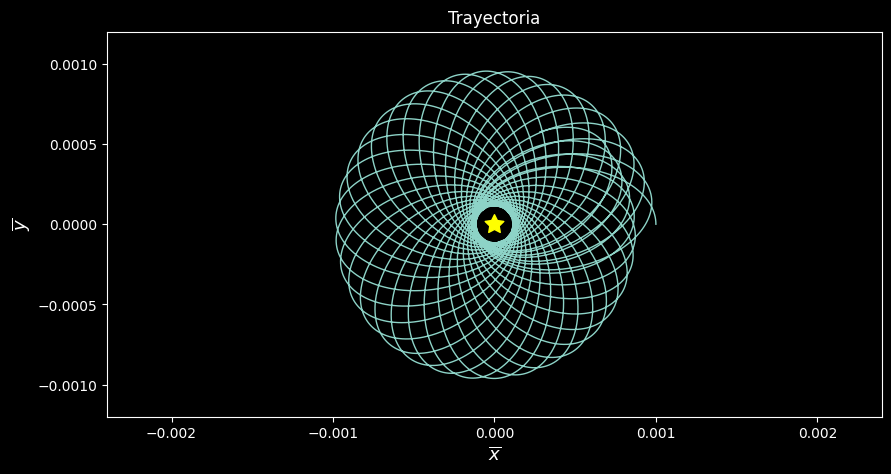

In [224]:
h = cond['h']; tf = cond['tf']; t = np.arange(0, tf+h, h); n = len(t)
dat = RK4(x0=cond['x0'], y0=cond['y0'], vx0=cond['vx0'], vy0=cond['vy0'], n=n, h=h, box=cond['box'])

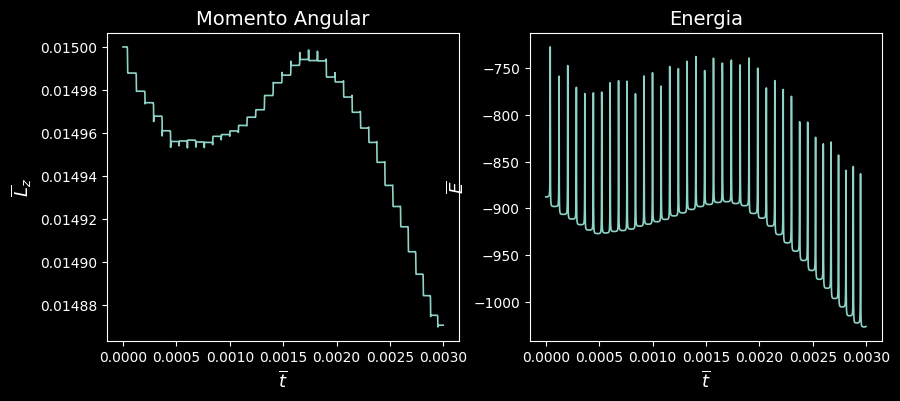

-887.6480594307066


In [225]:
## Obtener datos
t = dat['t'].values; E = dat['E'].values; L = dat['L'].values
x = dat['x'].values; y = dat['y'].values; vx = dat['vx'].values; vy = dat['vy'].values; 
Error = dat['Error'].values

## Graficas
t_0 = 0; t_f = cond['tf']
c0 = int(t_0/h); cf = int(t_f/h)  # Intervalos inicial para graficar

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Momento Angular', fontsize=14)
plt.plot(t[c0:cf],L[c0:cf],lw=1.2); plt.xlabel(r'$\overline{t}$',fontsize=13); plt.ylabel(r'$\overline{L}_z$',fontsize=13)
#plt.ylim(0.27,0.28)

plt.subplot(122)
#plt.plot(t[c0:cf],0.5*(vy[c0:cf]**2+vx[c0:cf]**2),'-r'); plt.title('Energía cinética')
#plt.plot(t[c0:cf],E[c0:cf]-vy[c0:cf]**2-vx[c0:cf]**2); plt.title('Energía potencial')
plt.plot(t[c0:cf],E[c0:cf],lw=1.2); plt.ylabel(r'$\overline{E}$',fontsize=13); plt.xlabel(r'$\overline{t}$',fontsize=13); plt.title('Energia', fontsize=14)
plt.savefig('images/RK4_Energia_Momentum.png',dpi=300)
plt.show()

print(E[0])

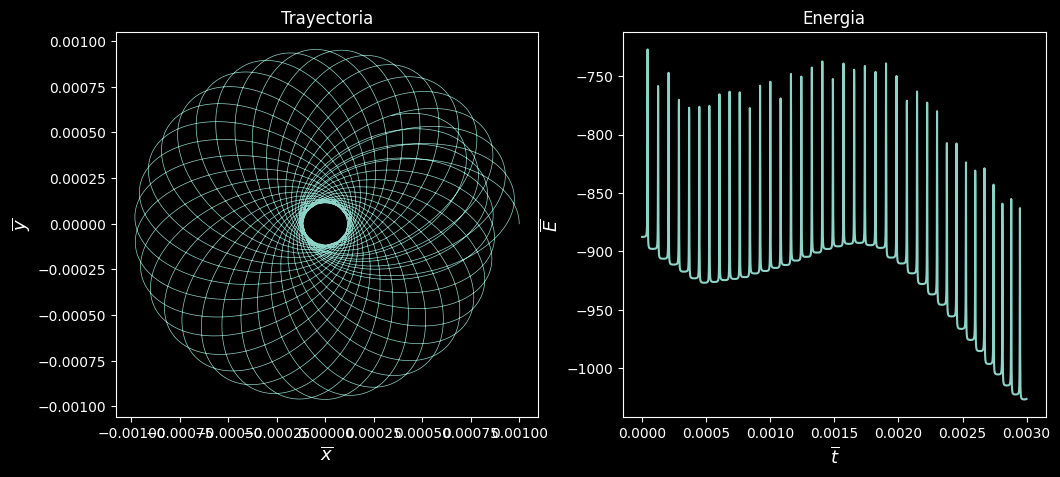

In [230]:
plt.figure(figsize=(12,5))
plt.subplot(121)
alpha = 0.5
plt.plot(x[c0:cf],y[c0:cf],lw=0.5); plt.title('Trayectoria')
#plt.plot(x[int(cf*alpha):cf],y[int(cf*alpha):cf],'-r',lw=0.5); plt.title('Trayectoria')
plt.xlabel(r'$\overline{x}$',fontsize=13); plt.ylabel(r'$\overline{y}$',fontsize=13)
#plt.xlim(-0.38,-0.3805); plt.ylim(-0.35330,-0.35275)

plt.subplot(122)
#plt.plot(t[c0:cf],0.5*(vy[c0:cf]**2+vx[c0:cf]**2)); plt.title('Energía cinética')
#plt.plot(t[c0:cf],E[c0:cf]-vy[c0:cf]**2-vx[c0:cf]**2); plt.title('Energía potencial')
plt.plot(t[c0:cf],E[c0:cf]); plt.title('Energia')
#plt.plot(t[int(cf*alpha):cf],E[int(cf*alpha):cf],'-r')
plt.xlabel(r'$\overline{t}$',fontsize=13); plt.ylabel(r'$\overline{E}$',fontsize=13)
plt.savefig('images/RK4_Trayectoria.png',dpi=300)
plt.show()

In [10]:
tref = np.sqrt(cte.au**3/(cte.G*cte.M_sun))
dref = cte.au
cref = cte.c*tref/dref

display(tref.to('d'))
display(dref)
display(cref)

<Quantity 58.13244088 d>

<<class 'astropy.constants.iau2015.IAU2015'> name='Astronomical Unit' value=149597870700.0 uncertainty=0.0 unit='m' reference='IAU 2012 Resolution B2'>

<Quantity 10065.32012197>

In [11]:
Torb*tref.to('d')

<Quantity 117.69153138 d>

In [12]:
Vorb*dref/tref

<Quantity 43445.43820503 m / s>